In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 8'

# QE band structure with SO interaction

The aim of this analysis is discuss the ground state property and the band structure of GaAs including the spin-orbit interaction. 

We use a full relativistic norm conserving (NC) psp based on LDA. With this choice Ga has 3 valence electrons and the minimum energy cutoff is 52 Ry, while As has 5 valence electrons and the suggested cutoff is 76 Ry.

## SCF calculation : convergence of the GS energy

As usual we perform a convergence procedure based on the total energy of the GS to fix the converged value of the cut-off energy and of the number of kpoints for the GS density

In [3]:
input = I.PwIn()
Ga = [0.,0.,0.]
As = [0.25,0.25,0.25]

input.set_pseudo_dir('../pseudos')
input.set_calculation('scf')

input.set_occupations('fixed')
input.system['ibrav'] = 2
input.system['celldm(1)'] = 10.677
input.system['noncolin'] = '.true'
input.system['lspinorb'] = '.true'
input.set_atoms_type(2)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='crystal',pos_list=[['Ga',Ga],['As',As]])
input.atypes = {'Ga': [69.72,'Ga_rel.pz-rrkj3.UPF'],\
                'As': [74.92,'As_rel.pz-rrkj3.UPF']}
input.set_convergence_thr(1e-8)

#print(input)

In [4]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 8 pw.x


In [5]:
gs_study = D.Dataset(label='gs_convergence',run_dir='gs_convergence',pre_processing='scf')

In [6]:
kpoints = [4,5,6,7] 
ecut = [20,40,60,80,100] # in Ry

In [7]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        input.set_prefix(D.name_from_id(idd))
        input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
        input.set_energy_cutoff(e)
        gs_study.append_run(id=idd,calculator=code,input=input)

In [8]:
gs_study.pre_processing_function()

Create folder gs_convergence


In [9]:
gs_study.run(post_processing=True)

execute : cd gs_convergence ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp ecut_20-k_4.in > ecut_20-k_4.log
parse file : gs_convergence/ecut_20-k_4.save/data-file-schema.xml
execute : cd gs_convergence ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp ecut_40-k_4.in > ecut_40-k_4.log
parse file : gs_convergence/ecut_40-k_4.save/data-file-schema.xml
execute : cd gs_convergence ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp ecut_60-k_4.in > ecut_60-k_4.log
parse file : gs_convergence/ecut_60-k_4.save/data-file-schema.xml
execute : cd gs_convergence ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp ecut_80-k_4.in > ecut_80-k_4.log
parse file : gs_convergence/ecut_80-k_4.save/data-file-schema.xml
execute : cd gs_convergence ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp ecut_100-k_4.in > ecut_100-k_4.log
parse file : gs_convergence/ecut_100-k_4.save/data-file-schema.xml
execute : cd gs_convergence ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp ecut_20-k_5.in > ecut_20-k_5.log
parse file : gs_convergence/ecut_20-k_5.sav

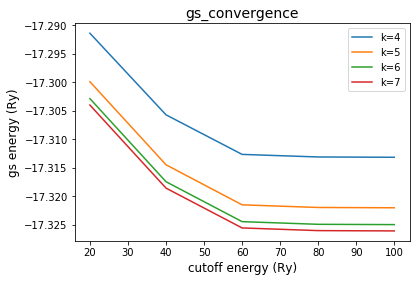

In [10]:
# E_tot gives the energy in Hartree and it is rescaled in Ry
for k in kpoints:
    data=gs_study.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,2*np.array(data),label='k='+str(k))
plt.title(gs_study.label,size=14)
plt.xlabel('cutoff energy (Ry)',size=12)
plt.ylabel('gs energy (Ry)',size=12)
plt.legend()
plt.show()

On this basis of this analysis we choose the converged parameters:

In [11]:
k_conv = 6
ecut_conv = 80

## NSCF calculation : computation of the band structure

We compute the band structure of the GaAs with the aim to determine the feature of the X, Gamma and L valleys
that are relevant for the subsequent pump and probe analysis.

Define a dictionary with the position of the high symmetry points of the GaAs lattice

In [12]:
G = [0.,0.,0.]
X = [1.,0.,0.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
#K = [0.75,0.75,0.]
high_sym = {'X':X,'L':L,'G':G,'W':W}

Bands are computed along the following path

In [13]:
numBands = 12
numStep = [30]
klist = [L+numStep,G+numStep,X+numStep,W+[0]]

In [14]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 8 pw.x


In [15]:
bnds_study = D.Dataset(label='bands',run_dir='qe_bands',pre_processing='nscf')

Append the chosen bands computations to the dataset. The idd, and consequently the prefix of this computation are chosen so that the scf.save folder with the converged kpoints and ecut parameters is used as input

In [16]:
input.set_calculation('nscf')
input.system['nbnd'] = numBands
idd = {'nbnd' : numBands} 
input.set_prefix(D.name_from_id(idd))
input.set_energy_cutoff(ecut_conv)
input.set_kpoints(ktype='tpiba_b',klist=klist)

bnds_study.append_run(id=idd,calculator=code,input=input)

In [17]:
bnds_study.pre_processing_function(source_dir='gs_convergence/ecut_80-k_6.save/')

Create folder qe_bands
execute :  cp -r gs_convergence/ecut_80-k_6.save/ qe_bands/nbnd_12.save


Run the dataset and extract the results of the (only) computation

In [18]:
bnds_study.run(post_processing=True)

execute : cd qe_bands ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp nbnd_12.in > nbnd_12.log
parse file : qe_bands/nbnd_12.save/data-file-schema.xml


Get the band structure

No handles with labels found to put in legend.


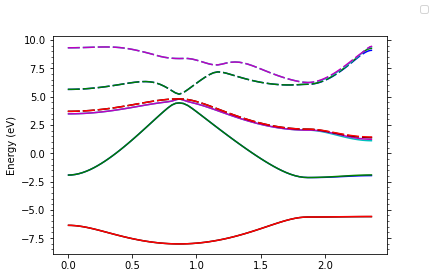

In [19]:
results = bnds_study.results[0]
bands = results.band_structure()

Plot the relevant band and identify the position of the high symmetry points on the path.

We use kpoints_cart.tolist() to add the position on the path to the high_sym dictionary

In [20]:
k_values = bands[:,0] # position on the path
kpoints_cart = results.kpt_cart # cartesian position for each value on the path
positions = []
labels = []
for point in high_sym:
    index = kpoints_cart.tolist().index(high_sym[point])
    labels.append(point)
    positions.append(k_values[index])

There are 8 electrons, the first band is bands[;1] since bands[;0] gives the k-points on the path. 
The last occupied band for spin up (down) is 7 (8). 
The first empty band is for spin up (down) is 9 (10)

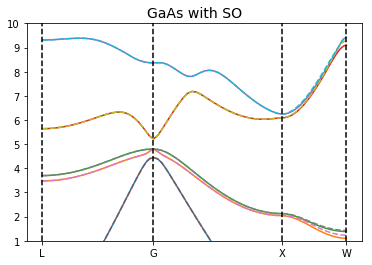

In [21]:
plotted_bands_up = [3,5,7,9,11]
plotted_bands_down = [4,6,8,10,12]
for b in plotted_bands_up:
    plt.plot(k_values,bands[:,b])

for b in plotted_bands_down:
    plt.plot(k_values,bands[:,b],ls='--')

for pos in positions:
    plt.axvline(pos,color='black',ls='--')

ax = plt.gca() # grab the current axis
ax.set_xticks(positions) # choose which x locations to have ticks
ax.set_xticklabels(labels) # set the labels to display at those ticks
plt.title('GaAs with SO',size = 14)
plt.ylim((1,10))
plt.show()

In [22]:
for lb, pos in zip(labels,positions):
    gap_up = bands[:,9][k_values.tolist().index(pos)]-bands[:,7][k_values.tolist().index(pos)]
    gap_down = bands[:,10][k_values.tolist().index(pos)]-bands[:,8][k_values.tolist().index(pos)]
    print('gap in',lb,'spin up : %.3f spin down : %.3f'%(gap_up,gap_down))

gap in X spin up : 3.968 spin down : 3.968
gap in L spin up : 1.941 spin down : 1.941
gap in G spin up : 0.418 spin down : 0.418
gap in W spin up : 7.711 spin down : 7.849


There seems to be an asymmetry in the W point.

We plot the difference between the energies of the valence and conduction bands for spin up and down along the whole path

[Text(0,0,'X'), Text(0,0,'L'), Text(0,0,'G'), Text(0,0,'W')]

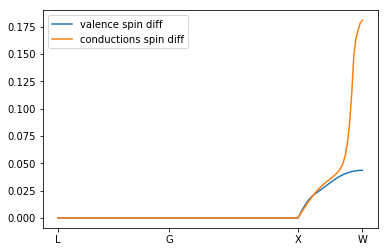

In [23]:
plt.plot(k_values,abs(bands[:,7]-bands[:,8]),label='valence spin diff')
plt.plot(k_values,abs(bands[:,9]-bands[:,10]),label='conductions spin diff')
plt.legend()
ax = plt.gca() # grab the current axis
ax.set_xticks(positions) # choose which x locations to have ticks
ax.set_xticklabels(labels) # set the labels to display at those ticks